#### Thaken from: https://www.kaggle.com/code/bloodaxe/deep-learning-for-satellite-image-processing


# Deep learning for satellite image processing

## 9th Data Science UA Conference 2020
### By [Eugene Khvedchenya](http://kaggle.com/bloodaxe/) (ekhvedchenya@gmail.com)

On this workshop you will learn how to apply deep learning to solve building damage assessment task. Given pair of images before and after natural disaster (wildfire, volcano eruption, flooding, etc.) one need to detect and classify level of damage dealt to buildings.

## What you will learn

*   How to build solid PyTorch training pipeline in Catalyst
*   How to train image segmentation model
*   How to build siamese dual-input segmentation model

## What you will need 

* PyTorch Deep learning framework
* Kaggle account (https://www.kaggle.com/)

## Hardward requirements

* A regular laptop/PC - all models training will happen in Kaggle Notebooks


![front-image2.ccf9f50d.jpg](https://xview2.org/img/front-image2.ccf9f50d.jpg)

## References

* [xBD: A Dataset for Assessing Building Damage from Satellite Imagery](https://arxiv.org/abs/1911.09296)
* [xView2 Data Challenge](https://xview2.org)
* [Eugene Khvedchenya's xView2 Solution](https://github.com/BloodAxe/xView2-Solution)


# Problem statement 

High resolution imagery is required to see the details of specific damage conditions in overhead imagery of a disaster area. However, the large areas affected by natural disasters combined with the huge numbers of pixels representing those areas make it laborious for analysts to search and evaluate specific buildings in a disaster area. The xView2 Challenge benchmarks automated computer vision capabilities for localizing and scoring the degree of damage to buildings before and after natural disasters.



<table align="left">
    <tr>
        <td>
  <img src="https://xview2.org/img/ex-pre.1df3ea2c.jpg" width="512" /><br><p align="center">Image before the distater</p>
        </td>
        <td>
  <img src="https://xview2.org/img/ex-post.fdc947c6.jpg" width="512" /><br><p align="center">Same area, after the disaster</p>
        </td>
    </tr>
</table>


Our goal is two-fold:
* Detect buildings in the first image
* Detect how much each building has been damaged after the disaster

<img align="left" src="https://xview2.org/img/ex-labeled.d0a0b19b.jpg" /><br/>



# Evaluation metric

In original competition target metric was weighted average of localization F1 and damage classification F1 scores. For sake of keeping the focus on modelling we will use **macro F1** on all classes (land, non-damaged building, light damage, major damage, destroyed). 

![F1](https://qph.fs.quoracdn.net/main-qimg-71d99f821819c3777bfab9b461864f01)


# Frameworks that we will use

In this workshop you will learn how to build advanced image segmentation model using PyTorch. To reduce the amount of boilerplate code, we will use [Catalyst](https://github.com/catalyst-team/catalyst) framework for quick & easy training of our models. Often, model architecture search is necessary to find the optimal model architecture, depth & width configuration of the network. To enable us to quicky change the encoder and decoder parameters of our model, we will use [pytorch-toolbelt](https://github.com/BloodAxe/pytorch-toolbelt) library which offers very flexible way to create building blocks of our model. And lastly, to ensure our model will not overfit, we will use [Albumentations](https://github.com/albumentations-team/albumentations) library to help us with image augmentations during the training.



In [1]:
!python --version
!pip uninstall -y typing
!pip install torch torchvision git+https://github.com/BloodAxe/catalyst git+https://github.com/BloodAxe/pytorch-toolbelt albumentations timm==0.2.1 iterative-stratification

Python 3.7.6
Found existing installation: typing 3.7.4.3
Uninstalling typing-3.7.4.3:
  Successfully uninstalled typing-3.7.4.3
  Cloning https://github.com/BloodAxe/catalyst to /tmp/pip-req-build-8dtian7_
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/BloodAxe/pytorch-toolbelt to /tmp/pip-req-build-45jevnwn
     |████████████████████████████████| 225 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 676 kB 5.3 MB/s eta 0:00:01


  Created wheel for catalyst: filename=catalyst-20.10.1-py3-none-any.whl size=478621 sha256=c087a0f6134b366d423c20aea44790e3dcace67b2f05f93eba7a2cc603c5e19c
  Stored in directory: /tmp/pip-ephem-wheel-cache-7s9nwhsx/wheels/07/55/db/c3a947a1c392ad3df1431f200350485ae2c27d51d0456a9bcd
  Created wheel for pytorch-toolbelt: filename=pytorch_toolbelt-0.4.1-py3-none-any.whl size=133763 sha256=06ea8215477d832c3c43c87d27d2fb3360f86a5a604c0d1fcd0fe3fd3b52b48f
  Stored in directory: /tmp/pip-ephem-wheel-cache-7s9nwhsx/wheels/34/81/f6/6bac03810803a706226c1d1c707b9a707d46c982d36e7626cd
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29745 sha256=a3a30ff7d64cf355271360b382a72faa7ecf38948b72e481430ac360f79a2035
  Stored in directory: /root/.cache/pip/wheels/93/17/b3/86db1d93e9dae198813aa79831b403e4844d67986cf93894b5
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655249 sha256=535aebf4f4bcacb9d392cc4e5863b5b42c2395c1a5bb7bf18ab24645ad742767
  Stor

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import gc
import torch

import albumentations as A

from typing import Union, List, Optional, Dict, Callable

from pytorch_toolbelt.utils import fs

from pytorch_toolbelt.utils import fs
from pytorch_toolbelt.utils.torch_utils import tensor_from_rgb_image, rgb_image_from_tensor, to_numpy, image_to_tensor 

from sklearn.utils import compute_sample_weight, compute_class_weight
from sklearn.model_selection import train_test_split

from collections import OrderedDict
from functools import partial

from pytorch_toolbelt.utils import maybe_cuda, count_parameters
from pytorch_toolbelt.modules import conv1x1, UnetBlock, ACT_RELU, ABN, ACT_SWISH
from pytorch_toolbelt.modules import encoders as E
from pytorch_toolbelt.modules.decoders import UNetDecoder
from pytorch_toolbelt.modules.encoders import EncoderModule, Resnet18Encoder, Resnet34Encoder, Resnet50Encoder, Resnet101Encoder, SEResNeXt50Encoder, DenseNet121Encoder
from pytorch_toolbelt.modules.encoders.timm import B0Encoder, B2Encoder, B3Encoder, B4Encoder, B6Encoder, DPN68Encoder, SKResNet18Encoder, SKResNeXt50Encoder
from pytorch_toolbelt.utils.catalyst import F1ScoreCallback

from torch import nn, Tensor
from torch.nn import functional as F
from torch.optim import SGD, Adam, RMSprop, AdamW
from torch.utils.data import Dataset, WeightedRandomSampler, ConcatDataset, DataLoader

from catalyst.dl import (
    SupervisedRunner,
    SchedulerCallback,
    CriterionCallback
)
from catalyst.utils import set_global_seed
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


# Let's look at the data

In [3]:
DATA_DIR = "../input/xview2-damage-assessment"


os.listdir(DATA_DIR)

['train.csv', 'train', 'test', 'tier3']

In [4]:
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
df

destroyed_buildings  destroyed_pixels         event_name event_type  \
0                        0                 0  guatemala-volcano       post   
1                        0                 0  guatemala-volcano        pre   
2                        0                 0  guatemala-volcano       post   
3                        0                 0  guatemala-volcano        pre   
4                        1              2498  guatemala-volcano       post   
...                    ...               ...                ...        ...   
18331                    0                 0       woolsey-fire        pre   
18332                    0                 0       woolsey-fire       post   
18333                    0                 0       woolsey-fire        pre   
18334                    0                 0       woolsey-fire       post   
18335                    0                 0       woolsey-fire        pre   

      folder                                        image_fname  \
0      train  train\images\guatemala-volcano_00000000_post_d...   
1      train  train\images\guatemala-volcano_00000000_pre_di...   
2      train  train\images\guatemala-volcano_00000001_post_d...   
3      train  train\images\guatemala-volcano_00000001_pre_di...   
4      train  train\images\guatemala-volcano_00000002_post_d...   
...      ...                                                ...   
18331  tier3  tier3\images\woolsey-fire_00000875_pre_disaste...   
18332  tier3  tier3\images\woolsey-fire_00000876_post_disast...   
18333  tier3  tier3\images\woolsey-fire_00000876_pre_disaste...   
18334  tier3  tier3\images\woolsey-fire_00000877_post_disast...   
18335  tier3  tier3\images\woolsey-fire_00000877_pre_disaste...   

                                       image_id  light_damaged_buildings  \
0      guatemala-volcano_00000000_post_disaster                        0   
1       guatemala-volcano_00000000_pre_disaster                        0   
2      guatemala-volcano_00000001_post_disaster                        4   
3       guatemala-volcano_00000001_pre_disaster                        0   
4      guatemala-volcano_00000002_post_disaster                        0   
...                                         ...                      ...   
18331        woolsey-fire_00000875_pre_disaster                        0   
18332       woolsey-fire_00000876_post_disaster                        0   
18333        woolsey-fire_00000876_pre_disaster                        0   
18334       woolsey-fire_00000877_post_disaster                        0   
18335        woolsey-fire_00000877_pre_disaster                        0   

       light_damaged_pixels  \
0                         0   
1                         0   
2                      2560   
3                         0   
4                         0   
...                     ...   
18331                     0   
18332                     0   
18333                     0   
18334                     0   
18335                     0   

                                              mask_fname  \
0      train\masks\guatemala-volcano_00000000_post_di...   
1      train\masks\guatemala-volcano_00000000_pre_dis...   
2      train\masks\guatemala-volcano_00000001_post_di...   
3      train\masks\guatemala-volcano_00000001_pre_dis...   
4      train\masks\guatemala-volcano_00000002_post_di...   
...                                                  ...   
18331  tier3\masks\woolsey-fire_00000875_pre_disaster...   
18332  tier3\masks\woolsey-fire_00000876_post_disaste...   
18333  tier3\masks\woolsey-fire_00000876_pre_disaster...   
18334  tier3\masks\woolsey-fire_00000877_post_disaste...   
18335  tier3\masks\woolsey-fire_00000877_pre_disaster...   

       medium_damaged_buildings  medium_damaged_pixels  non_damaged_buildings  \
0                             0                      0                      9   
1                             0                      0                      9   
2              

In [5]:

df = df.drop(columns=["light_damaged_pixels",
                      "destroyed_pixels",
                      "medium_damaged_pixels",
                      "non_damaged_pixels", 
                      "folder"])

df["key"] = df["event_name"] + df["sample_id"].apply(str)
df

destroyed_buildings         event_name event_type  \
0                        0  guatemala-volcano       post   
1                        0  guatemala-volcano        pre   
2                        0  guatemala-volcano       post   
3                        0  guatemala-volcano        pre   
4                        1  guatemala-volcano       post   
...                    ...                ...        ...   
18331                    0       woolsey-fire        pre   
18332                    0       woolsey-fire       post   
18333                    0       woolsey-fire        pre   
18334                    0       woolsey-fire       post   
18335                    0       woolsey-fire        pre   

                                             image_fname  \
0      train\images\guatemala-volcano_00000000_post_d...   
1      train\images\guatemala-volcano_00000000_pre_di...   
2      train\images\guatemala-volcano_00000001_post_d...   
3      train\images\guatemala-volcano_00000001_pre_di...   
4      train\images\guatemala-volcano_00000002_post_d...   
...                                                  ...   
18331  tier3\images\woolsey-fire_00000875_pre_disaste...   
18332  tier3\images\woolsey-fire_00000876_post_disast...   
18333  tier3\images\woolsey-fire_00000876_pre_disaste...   
18334  tier3\images\woolsey-fire_00000877_post_disast...   
18335  tier3\images\woolsey-fire_00000877_pre_disaste...   

                                       image_id  light_damaged_buildings  \
0      guatemala-volcano_00000000_post_disaster                        0   
1       guatemala-volcano_00000000_pre_disaster                        0   
2      guatemala-volcano_00000001_post_disaster                        4   
3       guatemala-volcano_00000001_pre_disaster                        0   
4      guatemala-volcano_00000002_post_disaster                        0   
...                                         ...                      ...   
18331        woolsey-fire_00000875_pre_disaster                        0   
18332       woolsey-fire_00000876_post_disaster                        0   
18333        woolsey-fire_00000876_pre_disaster                        0   
18334       woolsey-fire_00000877_post_disaster                        0   
18335        woolsey-fire_00000877_pre_disaster                        0   

                                              mask_fname  \
0      train\masks\guatemala-volcano_00000000_post_di...   
1      train\masks\guatemala-volcano_00000000_pre_dis...   
2      train\masks\guatemala-volcano_00000001_post_di...   
3      train\masks\guatemala-volcano_00000001_pre_dis...   
4      train\masks\guatemala-volcano_00000002_post_di...   
...                                                  ...   
18331  tier3\masks\woolsey-fire_00000875_pre_disaster...   
18332  tier3\masks\woolsey-fire_00000876_post_disaste...   
18333  tier3\masks\woolsey-fire_00000876_pre_disaster...   
18334  tier3\masks\woolsey-fire_00000877_post_disaste...   
18335  tier3\masks\woolsey-fire_00000877_pre_disaster...   

       medium_damaged_buildings  non_damaged_buildings  sample_id  \
0                             0                      9          0   
1                             0                      9          0   
2                             0                      0          1   
3                             0                      4          1   
4                             0                      0          2   
...                         ...                    ...        ...   
18331                         0                      0        875   
18332                         0                      0        876   
18333                         0                      0        876   
18334                         0                      0        877   
18335                         0                      0        877   

                      key  
0      guatemala-volcano0  
1      guatemala-volcano0  
2      guatemala-v

In [6]:
df_pre = df[df["event_type"] == "pre"]\
    .rename(columns={"image_fname": "image_fname_pre", "mask_fname": "mask_fname_pre"})\
    .drop(columns=["event_type", "image_id", "sample_id",
                      "light_damaged_buildings",
                      "destroyed_buildings",
                      "medium_damaged_buildings",
                      "non_damaged_buildings"])
df_post = df[df["event_type"] == "post"]\
    .rename(columns={"image_fname": "image_fname_post", "mask_fname": "mask_fname_post"})\
    .drop(columns=["event_name", "image_id", "event_type", "sample_id"])
df_all = df_pre.merge(df_post, on='key')
#df_all["total_buildings"] = df_all["destroyed_buildings"] + df_all["medium_damaged_buildings"] + df_all["light_damaged_buildings"] + df_all["non_damaged_buildings"]
df_all["damaged_buildings"] = df_all["destroyed_buildings"] + df_all["medium_damaged_buildings"] + df_all["light_damaged_buildings"]
print("Total samples", len(df_all))



Total samples 9168


**Disclaimer**: We have a little more than 9K pairs of images, which is quite a lot for training image segmentation model. However, Kaggle environment offers only dual-core CPU, which becomes a bottleneck in our training pipeline. So for the sake of staying within workshop time limit, we train our model using only a small part of the dataset - 300 train images and 50 test images.

No doubt, this small number of samples is anywhere close to enough number of training samples, however it is sufficient to evaluate different ideas in a controlled environment (With fixed random seed and determinictic GPU execution mode to ensure we're always training on exactly the same data samples). I encourage you to run these experiments on full training set and check whether our assumptions & findings holds true for larger number of samples.

In [7]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

df_all = df_all[df_all["damaged_buildings"] > 0].copy()
print("Samples with damaged buildings", len(df_all))

#train_df, valid_df = train_test_split(df_all, stratify=df_all["event_name"], test_size=0.2, shuffle=True, random_state=42)


mskf = MultilabelStratifiedKFold(n_splits=4, shuffle=True, random_state=0)
stratify_label = np.stack([
    df_all["non_damaged_buildings"].values > 0,
    df_all["light_damaged_buildings"].values > 0,
    df_all["medium_damaged_buildings"].values > 0,
    df_all["destroyed_buildings"].values > 0,
    
], axis=-1)

print(stratify_label.shape)

train_index, valid_index = next(mskf.split(df_all, stratify_label))

train_df = df_all.iloc[train_index]
valid_df = df_all.iloc[valid_index]

train_df = train_df.sort_values(by="damaged_buildings", ascending=False)[:300]
valid_df = valid_df.sort_values(by="damaged_buildings", ascending=False)[:60]
holdout_df = valid_df[50:]
valid_df = valid_df[:50]

print("Train samples", len(train_df))
print("Valid samples", len(valid_df))
print("Holdout samples", len(holdout_df))

train_img_pre = train_df["image_fname_pre"].apply(lambda x: os.path.abspath(os.path.join(DATA_DIR, x.replace("\\", "/")))).tolist()
train_img_post = train_df["image_fname_post"].apply(lambda x: os.path.abspath(os.path.join(DATA_DIR, x.replace("\\", "/")))).tolist()
train_mask_post = train_df["mask_fname_post"].apply(lambda x: os.path.abspath(os.path.join(DATA_DIR, x.replace("\\", "/")))).tolist()

valid_img_pre = valid_df["image_fname_pre"].apply(lambda x: os.path.abspath(os.path.join(DATA_DIR, x.replace("\\", "/")))).tolist()
valid_img_post = valid_df["image_fname_post"].apply(lambda x: os.path.abspath(os.path.join(DATA_DIR, x.replace("\\", "/")))).tolist()
valid_mask_post = valid_df["mask_fname_post"].apply(lambda x: os.path.abspath(os.path. os.path.join(DATA_DIR, x.replace("\\", "/")))).tolist()

holdout_img_pre = holdout_df["image_fname_pre"].apply(lambda x: os.path.abspath(os.path.join(DATA_DIR, x.replace("\\", "/")))).tolist()
holdout_img_post = holdout_df["image_fname_post"].apply(lambda x: os.path.abspath(os.path.join(DATA_DIR, x.replace("\\", "/")))).tolist()
holdout_mask_post = holdout_df["mask_fname_post"].apply(lambda x: os.path.abspath(os.path. os.path.join(DATA_DIR, x.replace("\\", "/")))).tolist()

Samples with damaged buildings 3240
(3240, 4)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning:

Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error



Train samples 300
Valid samples 50
Holdout samples 10


In [8]:
train_df

event_name                                    image_fname_pre  \
2946      joplin-tornado  tier3\images\joplin-tornado_00000147_pre_disas...   
746    hurricane-matthew  train\images\hurricane-matthew_00000156_pre_di...   
872    hurricane-matthew  train\images\hurricane-matthew_00000368_pre_di...   
859    hurricane-matthew  train\images\hurricane-matthew_00000346_pre_di...   
834    hurricane-matthew  train\images\hurricane-matthew_00000296_pre_di...   
...                  ...                                                ...   
573     hurricane-harvey  train\images\hurricane-harvey_00000392_pre_dis...   
263   hurricane-florence  train\images\hurricane-florence_00000428_pre_d...   
3585      nepal-flooding  tier3\images\nepal-flooding_00000119_pre_disas...   
1730        palu-tsunami  train\images\palu-tsunami_00000160_pre_disaste...   
3790      nepal-flooding  tier3\images\nepal-flooding_00000324_pre_disas...   

                                         mask_fname_pre  \
2946  tier3\masks\joplin-tornado_00000147_pre_disast...   
746   train\masks\hurricane-matthew_00000156_pre_dis...   
872   train\masks\hurricane-matthew_00000368_pre_dis...   
859   train\masks\hurricane-matthew_00000346_pre_dis...   
834   train\masks\hurricane-matthew_00000296_pre_dis...   
...                                                 ...   
573   train\masks\hurricane-harvey_00000392_pre_disa...   
263   train\masks\hurricane-florence_00000428_pre_di...   
3585  tier3\masks\nepal-flooding_00000119_pre_disast...   
1730  train\masks\palu-tsunami_00000160_pre_disaster...   
3790  tier3\masks\nepal-flooding_00000324_pre_disast...   

                        key  destroyed_buildings  \
2946      joplin-tornado147                  285   
746    hurricane-matthew156                   88   
872    hurricane-matthew368                   20   
859    hurricane-matthew346                    0   
834    hurricane-matthew296                   20   
...                     ...                  ...   
573     hurricane-harvey392                    1   
263   hurricane-florence428                    0   
3585      nepal-flooding119                    3   
1730        palu-tsunami160                   32   
3790      nepal-flooding324                    3   

                                       image_fname_post  \
2946  tier3\images\joplin-tornado_00000147_post_disa...   
746   train\images\hurricane-matthew_00000156_post_d...   
872   train\images\hurricane-matthew_00000368_post_d...   
859   train\images\hurricane-matthew_00000346_post_d...   
834   train\images\hurricane-matthew_00000296_post_d...   
...                                                 ...   
573   train\images\hurricane-harvey_00000392_post_di...   
263   train\images\hurricane-florence_00000428_post_...   
3585  tier3\images\nepal-flooding_00000119_post_disa...   
1730  train\images\palu-tsunami_00000160_post_disast...   
3790  tier3\images\nepal-flooding_00000324_post_disa...   

      light_damaged_buildings  \
2946                        4   
746                        83   
872                       222   
859                       279   
834                       215   
...                       ...   
573                         0   
263                         0   
3585                       24   
1730                        0   
3790                       10   

                                        mask_fname_post  \
2946  tier3\masks\joplin-tornado_00000147_post_disas...   
746   train\masks\hurricane-matthew_00000156_post_di...   
872   train\masks\hurricane-matthew_00000368_post_di...   
859   train\masks\hurricane-matthew_00000346_post_di...   
834   train\masks\hurricane-matthew_00000296_post_di...   
...                                                 ...   
573   train\masks\hurricane-harvey_00000392_post_dis...   
263   train\masks\hurricane-florence_00000428_post_d...   
3585  tier3\masks\nepal-flooding_00000119_post_disas...   
1730  train\masks\palu-tsunami_0000

In [9]:
print(train_df["event_name"].unique())

['joplin-tornado' 'hurricane-matthew' 'hurricane-harvey' 'moore-tornado'
 'santa-rosa-wildfire' 'palu-tsunami' 'hurricane-michael'
 'tuscaloosa-tornado' 'nepal-flooding' 'woolsey-fire' 'hurricane-florence'
 'socal-fire' 'lower-puna-volcano' 'portugal-wildfire']


In [10]:
INPUT_IMAGE_KEY = "image"
INPUT_INDEX_KEY = "index"

INPUT_IMAGE_PRE_KEY = "image_pre"
INPUT_IMAGE_POST_KEY = "image_post"

INPUT_IMAGE_ID_KEY = "image_id"
INPUT_BUILDINGS_MASK_KEY = "buildings_mask"
INPUT_DAMAGE_MASK_KEY = "damage_mask"


OUTPUT_DAMAGE_MASK_KEY = "predicted_damage_mask"

def read_image_rgb(fname):
    image = cv2.imread(fname)[..., ::-1]
    if image is None:
        raise FileNotFoundError(fname)
    return image


def read_mask(fname):
    from PIL import Image
    mask = np.array(Image.open(fname))  # Read using PIL since it supports palletted image
    if len(mask.shape) == 3:
        mask = np.squeeze(mask, axis=-1)

    return mask
    
def overlay_damage_mask(image, mask):
    overlay = image.copy()
    overlay[mask == 1] = (0,   255, 0) # Regular buildingn are green
    overlay[mask == 2] = (255, 255, 0) # Destroyed buildings are yellow
    overlay[mask == 3] = (255,  69, 0) # Destroyed buildings are orange
    overlay[mask == 4] = (255,   0, 0) # Destroyed buildings are red
    return cv2.addWeighted(overlay, 0.5, image, 0.5, 0, dtype=cv2.CV_8U)

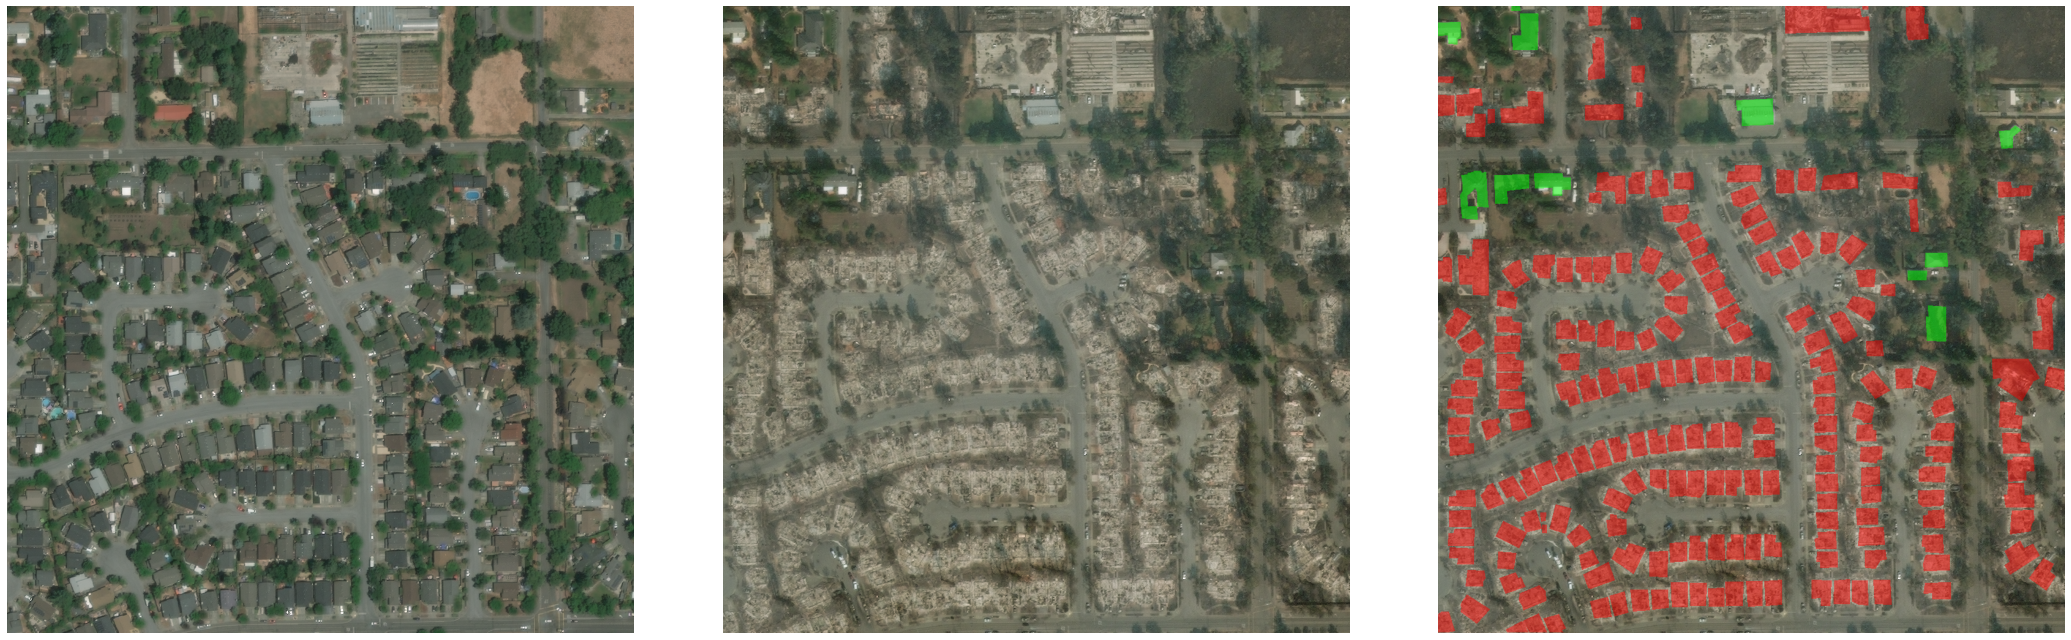

In [11]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,3, figsize=(30,9))
ax[0].imshow(read_image_rgb(train_img_pre[16]))
ax[0].axis('off')
ax[1].imshow(read_image_rgb(train_img_post[16]))
ax[1].axis('off')
ax[2].imshow(overlay_damage_mask(
    read_image_rgb(train_img_post[16]),
    read_mask(train_mask_post[16])
))
ax[2].axis('off')
f.tight_layout()
f.show()

# Image Augmentations
![Albumentations](https://camo.githubusercontent.com/16b1b10ec83ffa96034bce1d8c7fc56b31c4f7a8/68747470733a2f2f616c62756d656e746174696f6e732e72656164746865646f63732e696f2f656e2f6c61746573742f5f7374617469632f6c6f676f2e706e67)

Since we work only with small portion of the training set, it's important to more diversity to our images by adding on-the-fly image augmentations. We can safely rotate our images and masks, slight change their scale, brightness and color during training. This would increase model's generalization and prevent overfitting. The only trick is not to forget augment image and corresponding mask consistently. 
The [albumentations](https://github.com/albumentations-team/albumentations) library works with images and masks at the same time, which is what we need. Let's take a look at the example:



## Albumentations crash course

Docs: https://albumentations.ai/docs/
Examples: https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/pytorch_semantic_segmentation.ipynb

Let's augment single pair of images and see what happens:

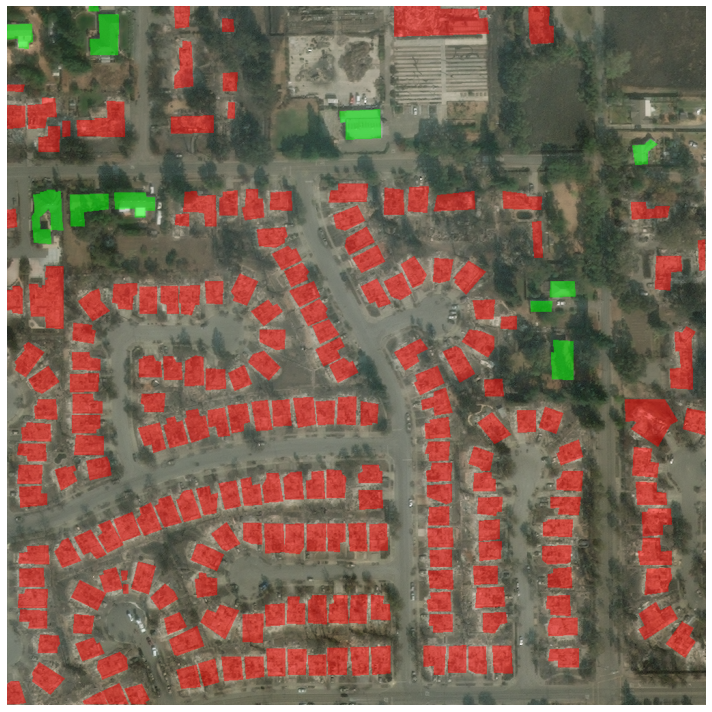

In [12]:
def show_image(image):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
sample_image = read_image_rgb(train_img_post[16])
sample_mask = read_mask(train_mask_post[16])

show_image(overlay_damage_mask(sample_image, sample_mask))

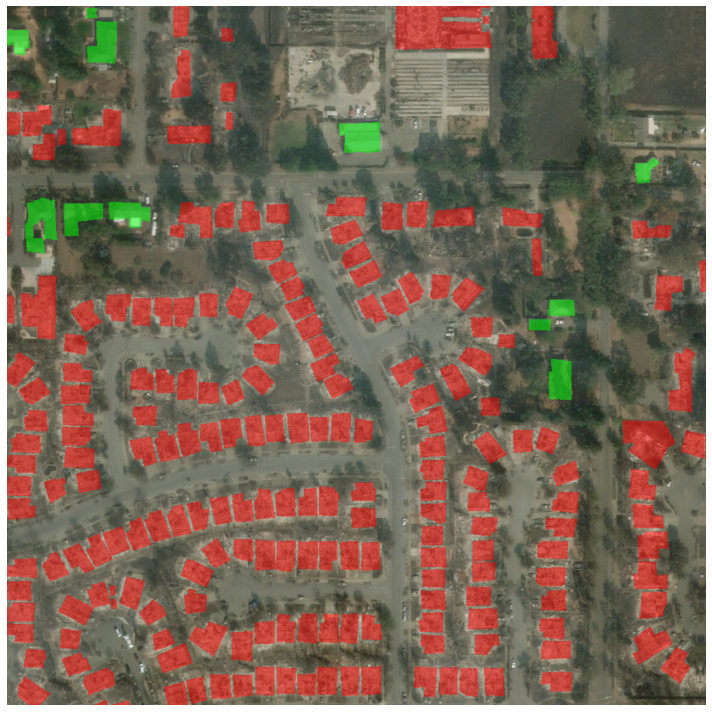

In [13]:
transform = A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, p=1)
augmented = transform(image=sample_image, mask=sample_mask)

show_image(overlay_damage_mask(augmented["image"], augmented["mask"]))


Awesome! Now, let's apply several augmentations sequentially. With Albumentations you can write really sophisticated augmentations. Here we use A.Compose to perform sequential composition of two augmentations: 

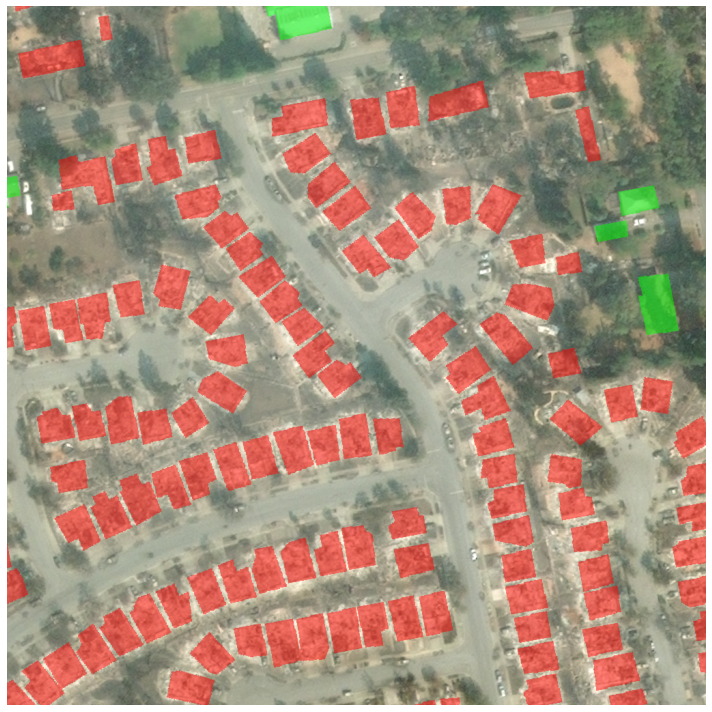

In [14]:
sample_image = read_image_rgb(train_img_post[16])
sample_mask = read_mask(train_mask_post[16])

transform = A.Compose([
    A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=15, p=1, border_mode=cv2.BORDER_REFLECT),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1),
])

augmented = transform(image=sample_image, mask=sample_mask)

show_image(overlay_damage_mask(augmented["image"], augmented["mask"]))

**Task**: Try adjusting parameters for `A.RandomShiftScale` and `A.RandomBrightnessContrast` and see how it affects the augmented image. Try to find boundary, where generated images are "way too far off" from the original. 

## Training augmentations

Pro Tip: Try playing with `A.Posterize`, `A.CLAHE`, `A.HueSaturationValue` for color augmentations and `A.MaskDropout`, `A.ElasticTransform` and `A.RandomGridShuffle` for spatial augmentations. See https://github.com/albumentations-team/albumentations for all showsace notebooks.

In [15]:
color_augmentations = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, brightness_by_max=True, p=0.5),
    A.RandomGamma(gamma_limit=(90, 110)),
    A.Normalize()
])


spatial_augmentations = A.Compose([
    # Random crop training samples to 512x512 patches
    A.RandomSizedCrop((512-64, 512+64), 512, 512),
    # D4
    A.RandomRotate90(p=1),
    A.Transpose(p=0.5),
    # Random rotate
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=5,
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        mask_value=0,
    ),    
])

Now it's time to write our dataset class. In PyTorch, we have a concept of the Dataset. It's contract to provide training & validation samples during the training loop. Each sample in our dataset is a pair of images (corresponding to pre- and post- event photo of the area) and corresponding damage mask. Pre- and post- images are already aligned. Typicaly, segmentation models works with only one image, but we can 'pretend' we have only one image by concatenating then via channels dimension. So instead of having two RGB images we will get one 6-channel RGBRGB image. If necessary, we can always split it back into two images inside the model.



In [16]:
class ImageMaskDataset(Dataset):
    def __init__(
        self,
        pre_image_filenames: List[str],
        post_image_filenames: List[str],
        post_mask_filenames: Optional[List[str]],
        spatial_transform: A.Compose,
        color_transform: A.Compose = None,
    ):
        assert len(pre_image_filenames) == len(post_image_filenames)

        self.pre_image_filenames = pre_image_filenames
        self.post_image_filenames = post_image_filenames
        self.post_mask_filenames = post_mask_filenames

        self.spatial_transform = spatial_transform
        self.color_transform = color_transform

    def __len__(self):
        return len(self.pre_image_filenames)

    def __getitem__(self, index):
        pre_image = read_image_rgb(self.pre_image_filenames[index]) # 1024x1024x3
        post_image = read_image_rgb(self.post_image_filenames[index]) # 1024x1024x3
        mask = read_mask(self.post_mask_filenames[index]) # 1024x1024
        
        if self.color_transform is not None:
            pre_image = self.color_transform(image=pre_image)["image"]
            post_image = self.color_transform(image=post_image)["image"]

        image = np.dstack([pre_image, post_image]) # 1024x1024x6
        
        if self.spatial_transform is not None:
            data = self.spatial_transform(image=image, mask=mask)
            image = data["image"]
            mask = data["mask"]
            
        sample = {
            INPUT_INDEX_KEY: index,
            INPUT_IMAGE_ID_KEY: fs.id_from_fname(self.pre_image_filenames[index]),
            INPUT_IMAGE_KEY: image_to_tensor(image),
            INPUT_BUILDINGS_MASK_KEY: torch.from_numpy(mask > 0).long(),
            INPUT_DAMAGE_MASK_KEY: torch.from_numpy(mask).long()
        }

        return sample


In [17]:
train_ds = ImageMaskDataset(
    train_img_pre,
    train_img_post,
    train_mask_post,
    spatial_transform=spatial_augmentations,
    color_transform=color_augmentations,
)

valid_ds = ImageMaskDataset(
    valid_img_pre,
    valid_img_post,
    valid_mask_post,
    color_transform=A.Normalize(),
    spatial_transform=None,
)

print(len(train_ds), len(valid_ds))

300 50


In [18]:
def show_sample(sample: Dict[str, Tensor]):    
    image_pre = rgb_image_from_tensor(sample[INPUT_IMAGE_KEY][0:3])
    image_post = rgb_image_from_tensor(sample[INPUT_IMAGE_KEY][3:6])
    damage_mask = to_numpy(sample[INPUT_DAMAGE_MASK_KEY])
    
    f, ax = plt.subplots(1,3, figsize=(30,9))
    ax[0].imshow(image_pre)
    ax[0].axis('off')
    ax[1].imshow(image_post)
    ax[1].axis('off')
    ax[2].imshow(overlay_damage_mask(image_post, damage_mask))
    ax[2].axis('off')
    f.tight_layout()
    f.show()

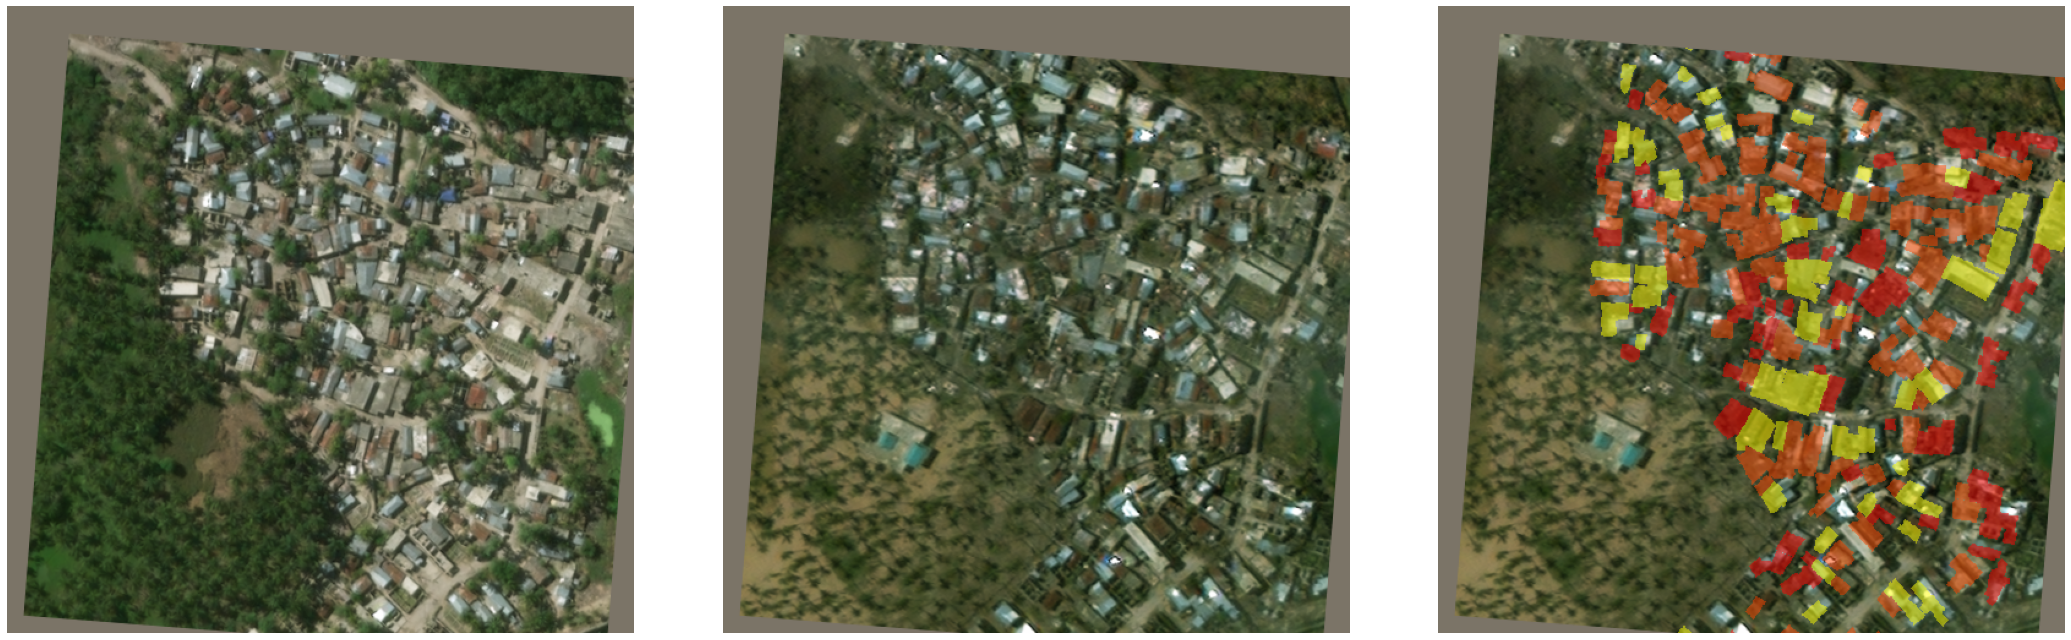

In [19]:
show_sample(train_ds[1])

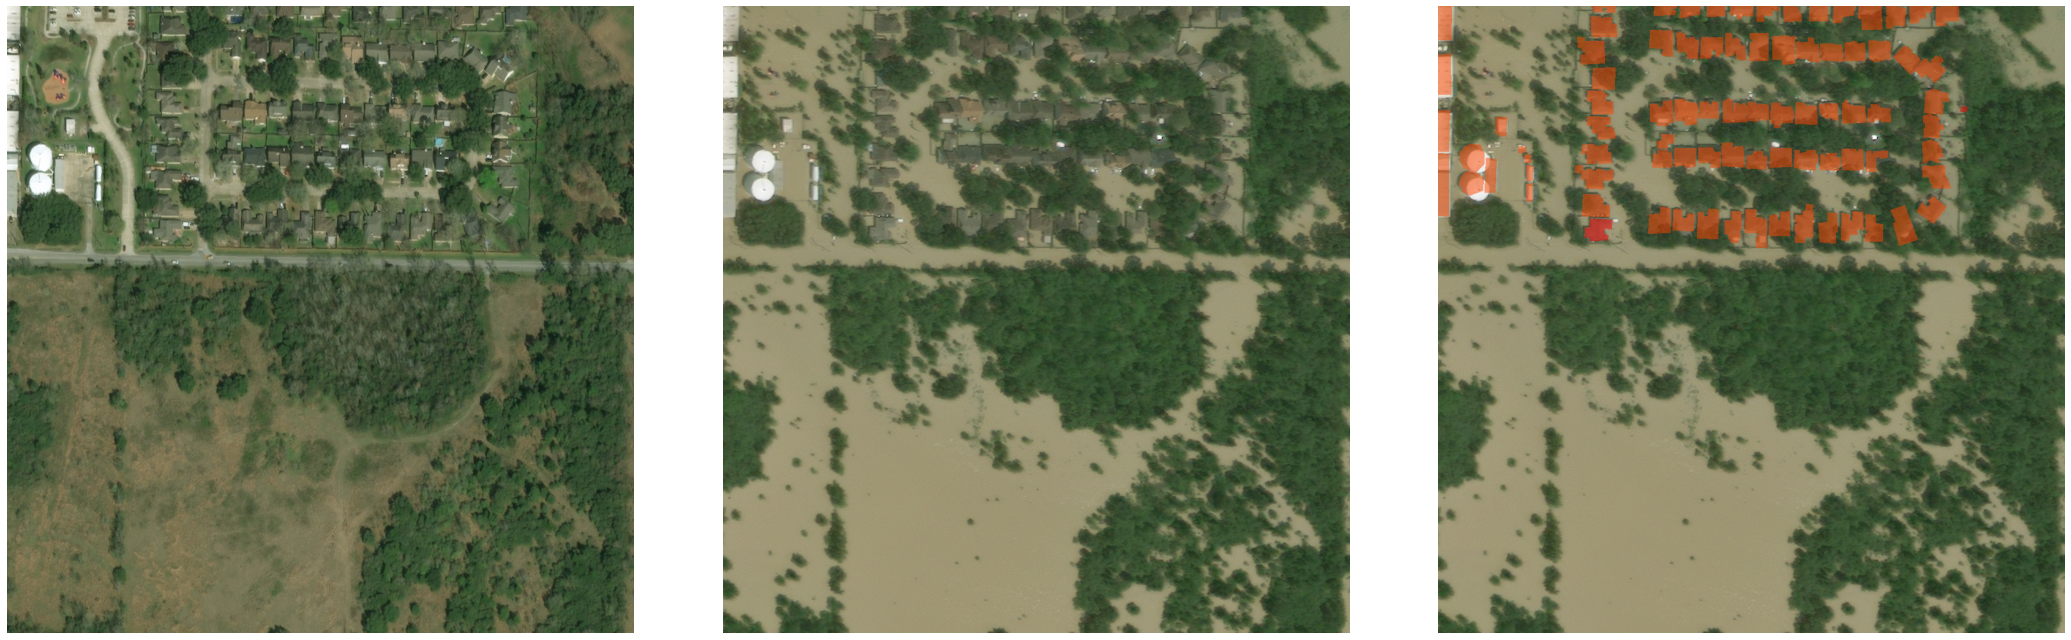

In [20]:
show_sample(valid_ds[40])

# Build segmentation model

There are plenty of deep learning architectures for image segmentation. The vast majority of them follows encoder-decoder principle, in which Encoder part responsible for extracting semantic representation from the image, and task of the decoder is to reconstruct dense predictions map (mask). The most famous architectures are:

* U-Net
* Ternaus-Net
* Link-Net
* PSPNet
* FPN
* DeepLab
* Panoptic DeepLab
* HRNet
* Hourglass Networks
* U2Net

Each architecture has it's own pros and cons. More specificaly - U-Net architecture tends to be quite accurate and can perform pixel-perfect predictions. PSPNet and DeepLab models shows best performance in dealing with segmentation of large number of classes. Panoptic DeepLab suitable for instance segmentation. 

In this workshop we will use Encoder-Decoder segmentation model similar to U-Net. For the encoder part we will use pre-trained feature extractors from EfficientNet and ResNet families. Use of pre-trained encoders greatly improves training speed and final accuracy of the trained model.

A U-NET is a convolutional neural network that was initially developed for biomedical image segmentation but has since proven its value for all image segmentation task no matter what specific topic.

![U-Net](https://miro.medium.com/max/1838/0*wPTXmX2_TqKwBy9i.png)
(https://arxiv.org/abs/1505.04597)

Despite vanilla U-Net is well-known and proven architecture, we can do better. With some help from pytorch-toolbelt we can do model surgery and attach pre-trained encoder like ResNet34 or EfficientNetB4 to U-Net decoder. By using pre-trained encoder we increase speed of the convergence and overall model's performance (Iglovikov et. al https://arxiv.org/abs/1801.05746). This can be also considered as transfer-learning appoach, where we train decoder part and fine-tuning encoder jointly. 

In [21]:
from collections import OrderedDict
from functools import partial
from typing import Union, List, Dict

from pytorch_toolbelt.modules import conv1x1, UnetBlock, ACT_RELU, ABN, ACT_SWISH
from pytorch_toolbelt.modules import encoders as E
from pytorch_toolbelt.modules.decoders import UNetDecoder
from pytorch_toolbelt.modules.encoders import EncoderModule
from pytorch_toolbelt.modules.encoders.timm import *

from torch import nn, Tensor
from torch.nn import functional as F


class UnetSegmentationModel(nn.Module):
    def __init__(
        self,
        encoder: EncoderModule,
        unet_channels: Union[int, List[int]],
        num_classes: int = 1,
        dropout=0.25,
        full_size_mask=True,
        activation=ACT_RELU,
        upsample_block=nn.UpsamplingNearest2d,
        need_supervision_masks=False,
        last_upsample_block=None,
    ):
        super().__init__()
        self.encoder = encoder

        abn_block = partial(ABN, activation=activation)
        self.decoder = UNetDecoder(
            feature_maps=encoder.channels,
            decoder_features=unet_channels,
            unet_block=partial(UnetBlock, abn_block=abn_block),
            upsample_block=upsample_block,
        )

        self.mask = nn.Sequential(
            OrderedDict([("drop", nn.Dropout2d(dropout)), ("conv", conv1x1(unet_channels[0], num_classes))])
        )


    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        x_size = x.size()
        x = self.encoder(x)
        x = self.decoder(x)

        # Decode mask
        mask = self.mask(x[0])
        mask = F.interpolate(mask, size=x_size[2:], mode="bilinear", align_corners=False)

        output = {OUTPUT_DAMAGE_MASK_KEY: mask}
        return output

    
def b4_unet32(input_channels=6, num_classes=5, dropout=0.1, pretrained=True):
    # We take outputs of stages 1,2,3,4 which corresponds to strides 4,8,16,32
    encoder = B4Encoder(pretrained=pretrained, layers=[1,2,3,4])
    if input_channels != 3:
        encoder.change_input_channels(input_channels)

    return UnetSegmentationModel(
        encoder, num_classes=num_classes, unet_channels=[32, 64, 128], activation=ACT_SWISH, dropout=dropout
    )

# Training time!

![Catalyst](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/catalyst_logo.png)

We use Catalyst framework to instead of pure PyTorch training loop. Catalyst brings us numerous advantages:

* Automatic support of mixed-precision training
* Support of training on TPU
* Tracking of metrics and automatic saving of the best model
* Simple, clear training loop that fits into one screen

There are key componenets, that you need to pass to Catalyst runner - datasets, model, criterion and optimizer.

In [22]:
DEFAULT_LR = 1e-3
DEFAULT_NUM_EPOCHS = 10
DEFAULT_BATCH_SIZE = 20
DEFAULT_NUM_WORKERS = 3

In [23]:
def train_closure(model, batch_size:int, experiment_name:str, epochs=DEFAULT_NUM_EPOCHS, workers=DEFAULT_NUM_WORKERS):
    set_global_seed(42)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    # Define our data loaders
    loaders = OrderedDict([
        ("train", DataLoader(
            train_ds,
            batch_size=batch_size,
            num_workers=workers,
            pin_memory=True,
            drop_last=True,
            shuffle=True,
        )),
        ("valid", DataLoader(
            valid_ds,
            batch_size=batch_size // 4,
            num_workers=workers,
            pin_memory=True,
            shuffle=False,
        ))
    ])
    
    print("Experiment",experiment_name)
    print("Model", count_parameters(model))

    runner = SupervisedRunner(input_key=INPUT_IMAGE_KEY, output_key=None)
    runner.train(
      fp16 = {"amp": True},
      model = model,
      criterion = {
          "ce": nn.CrossEntropyLoss()
      },
      # Define what optimizer we will use
      optimizer=Adam(model.parameters(), lr=DEFAULT_LR),
      scheduler=None,
      callbacks=[
        CriterionCallback(
            input_key=INPUT_DAMAGE_MASK_KEY,
            output_key=OUTPUT_DAMAGE_MASK_KEY,
            criterion_key="ce"),
        F1ScoreCallback(
            prefix="f1",
            input_key=INPUT_DAMAGE_MASK_KEY,
            output_key=OUTPUT_DAMAGE_MASK_KEY,
            num_classes=5
        )
      ],
      loaders = loaders,
      logdir=os.path.join("logs", experiment_name),
      num_epochs=epochs,
      verbose=True,
      main_metric="f1",
      minimize_metric=False,
    )
    
    best_f1_score = runner.best_valid_metrics["f1"]
    best_checkpoint_fname = os.path.join(runner.experiment.logdir, "checkpoints", "best.pth")
    del runner, model
    gc.collect()
    torch.cuda.empty_cache()
    
    return best_checkpoint_fname, best_f1_score


In [ ]:
best_checkpoint_fname, best_f1 = train_closure(model=b4_unet32(), batch_size=20, experiment_name="b4_unet32")
print(best_checkpoint_fname, best_f1)

# Visualizing predictions

Let's take a look what predictions our model can make at this point. We use holdout dataset here to ensure we're not overfitting to the validation set.  

In [ ]:
@torch.no_grad()
def predict(model, image_pre, image_post):
    if isinstance(image_pre, str):
        image_pre = read_image_rgb(image_pre)
    if isinstance(image_post, str):
        image_post = read_image_rgb(image_post)
        
    normalize = A.Normalize()
    image = np.dstack([
        normalize(image=image_pre)["image"],
        normalize(image=image_post)["image"],
    ])
    model_input = image_to_tensor(image).unsqueeze(0).cuda()
    outputs = model.eval()(model_input)
    
    mask = outputs[OUTPUT_DAMAGE_MASK_KEY].argmax(dim=1)
    return to_numpy(mask[0])

def show_predictions(image, gt_mask, pred_mask):
    f, ax = plt.subplots(1, 3, figsize=(30,10))
    
    gt_overlay = overlay_damage_mask(image, gt_mask)
    pred_overlay = overlay_damage_mask(image, pred_mask)
    
    ax[0].imshow(image)
    ax[0].axis('off')

    ax[1].imshow(gt_overlay)
    ax[1].axis('off')

    ax[2].imshow(pred_overlay)
    ax[2].axis('off')
    
    f.tight_layout()
    f.show()

In [ ]:
# Recreate the model and load weights from the best checkpoint
model = b4_unet32().cuda()
model.load_state_dict(torch.load(best_checkpoint_fname)["model_state_dict"])

# Run the predictions
for i in range(len(holdout_mask_post)):
    gt_mask = read_mask(holdout_mask_post[i])
    image_pre = read_image_rgb(holdout_img_pre[i])
    image_post = read_image_rgb(holdout_img_post[i])
    pred_mask = predict(model, image_pre, image_post)
    
    show_predictions(image_post, gt_mask, pred_mask)

del model

# Let's compare B4 to ResNet-18

Both B4 and ResNet-18 has similar number of parameters, so why not compare them?

In [ ]:
def resnet18_unet32(input_channels=6, num_classes=5, dropout=0.1, pretrained=True):
    # We take outputs of stages 1,2,3,4 which corresponds to strides 4,8,16,32
    encoder = Resnet18Encoder(pretrained=pretrained, layers=[1,2,3,4])
    if input_channels != 3:
        encoder.change_input_channels(input_channels)

    return UnetSegmentationModel(
        encoder, num_classes=num_classes, unet_channels=[32, 64, 128], activation=ACT_RELU, dropout=dropout
    )

In [ ]:
best_checkpoint_fname, best_f1 = train_closure(model=resnet18_unet32(), batch_size=20, experiment_name="resnet18_unet32")
print(best_checkpoint_fname, best_f1)

It seems, ResNet18 performs much worse, than B4. This comes with no surprise, but it is always worth checking different architectures. Maybe we long-enough training or bigger ResNet you can get similar score to the EfficientNet-s.

# Optimizing the loss

So far we've trained our segmentation model using cross-entropy loss, which does not account balance of classes in the dataset. It is safe to assume most of the pixels in the images will belong to "not building" (label zero), but we don't have any clues on the distribution of the damaged class labels. Let's fix that.

First, we compute counts of the pixels belonging to each label, and then - assign class labels in weighted cross-entropy loss.

In [ ]:
labels_count = np.zeros(5)
for mask_fname in train_mask_post:
    mask = read_mask(mask_fname)
    labels_count = np.bincount(mask.flatten(), minlength=5)
    
print("Not building", "No damage", "Light", "Medim", "Destroyed")
print(labels_count)

Clearly, there is a strong class imbalance towards not-building class and under represented "destroyed building" class. Let's try to fix this by adding class weights to cross-entropy loss:

In [ ]:
# Task: Assign class weights based on labels count
ce_class_weights = np.ones_like(labels_count)

print(ce_class_weights)

def train_closure_with_weighted_ce(model, batch_size:int, experiment_name:str, epochs=DEFAULT_NUM_EPOCHS, workers=DEFAULT_NUM_WORKERS):
    set_global_seed(42)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    # Define our data loaders
    loaders = OrderedDict([
        ("train", DataLoader(
            train_ds,
            batch_size=batch_size,
            num_workers=workers,
            pin_memory=True,
            drop_last=True,
            shuffle=True,
        )),
        ("valid", DataLoader(
            valid_ds,
            batch_size=batch_size // 4,
            num_workers=workers,
            pin_memory=True,
            shuffle=False,
        ))
    ])
    
    print("Experiment",experiment_name)
    print("Model", count_parameters(model))

    runner = SupervisedRunner(input_key=INPUT_IMAGE_KEY, output_key=None)
    runner.train(
      fp16 = {"amp": True},
      model = model,
      criterion = {
          "weighted_ce": nn.CrossEntropyLoss(weight=torch.tensor(ce_class_weights).float().cuda())
      },
      # Define what optimizer we will use
      optimizer=Adam(model.parameters(), lr=DEFAULT_LR),
      scheduler=None,
      callbacks=[
        CriterionCallback(
            input_key=INPUT_DAMAGE_MASK_KEY,
            output_key=OUTPUT_DAMAGE_MASK_KEY,
            criterion_key="weighted_ce"),
        F1ScoreCallback(
            prefix="f1",
            input_key=INPUT_DAMAGE_MASK_KEY,
            output_key=OUTPUT_DAMAGE_MASK_KEY,
            num_classes=5
        )
      ],
      loaders = loaders,
      logdir=os.path.join("logs", experiment_name),
      num_epochs=epochs,
      verbose=True,
      main_metric="f1",
      minimize_metric=False,
    )
    
    best_f1_score = runner.best_valid_metrics["f1"]
    best_checkpoint_fname = os.path.join(runner.experiment.logdir, "checkpoints", "best.pth")
    del runner, model
    gc.collect()
    torch.cuda.empty_cache()
    
    return best_checkpoint_fname, best_f1_score


In [ ]:
best_checkpoint_fname, best_f1 = train_closure_with_weighted_ce(model=b4_unet32(), batch_size=20, experiment_name="b4_unet32_weighted_ce")
print(best_checkpoint_fname, best_f1)

# Recreate the model and load weights from the best checkpoint
model = b4_unet32().cuda()
model.load_state_dict(torch.load(best_checkpoint_fname)["model_state_dict"])

# Run the predictions
for i in range(len(holdout_mask_post)):
    gt_mask = read_mask(holdout_mask_post[i])
    image_pre = read_image_rgb(holdout_img_pre[i])
    image_post = read_image_rgb(holdout_img_post[i])
    pred_mask = predict(model, image_pre, image_post)
    
    show_predictions(image_post, gt_mask, pred_mask)

# Changing model architecture

So far we've been using 6-channel image as direct input to U-Net model. But there is another approach to this problem - hybrid siamese networks. In siamese networks we have two networks, that share same weights working in tanderm on two different inputs to compute comparable output vectors. We may adopt this approach for assessing damage buildings. In xView 2 Challenge I took the third place with exactly this approach. It proved to work much better than baseline.

Here's an idea - we use image encoder independently for pre- and post- images and we concatenate features from the encoder path. In this case, encoder and decoder lears feature maps that are uncorrelated between pre- and post and it is the decoder part to find the differences in visual appearance of the buildings and based on this - assign damage label.

![Siamese U-Net](https://github.com/BloodAxe/xView2-Solution/releases/download/v1.0/siamese_unet.png)

In [ ]:
class SiameseUnetSegmentationModel(nn.Module):
    def __init__(
        self,
        encoder: EncoderModule,
        num_classes: int,
        unet_channels: List[int],
        dropout=0.25,
        abn_block: Union[ABN, Callable[[int], nn.Module]] = ABN,
        full_size_mask=True,
        activation=ACT_RELU,
        upsample_block=nn.UpsamplingNearest2d,
    ):
        super().__init__()
        self.encoder = encoder

        feature_maps = [2 * fm for fm in encoder.channels]
        
        abn_block = partial(ABN, activation=activation)
        self.decoder = UNetDecoder(
            feature_maps=feature_maps,
            decoder_features=unet_channels,
            unet_block=partial(UnetBlock, abn_block=abn_block),
            upsample_block=upsample_block,
        )

        self.mask = nn.Sequential(
            OrderedDict([("drop", nn.Dropout2d(dropout)), ("conv", conv1x1(unet_channels[0], num_classes))])
        )        

    def forward(self, image):
        batch_size = image.size(0)
        # Split input image batch into pre- and post- batches
        pre, post = image[:, 0:3, ...], image[:, 3:6, ...] # [B,3,H,W], [B,3,H,W]
        
        # Concatenate them along batch dimension since it's faster than calling self.encoder(pre), self.encoder(post)
        x = torch.cat([pre, post], dim=0) # [2 * B, 3, H, W]
        
        # Encoder
        features = self.encoder(x) # List[Tensor] of strides 4,8,16,32
        
        pre_features = [f[0: batch_size] for f in features]
        post_features = [f[batch_size: batch_size * 2] for f in features]
        features = [torch.cat([pre, post], dim=1) for pre, post in zip(pre_features, post_features)]
        
        # Decoder part
        features = self.decoder(features)
        
        # Decode mask
        mask = self.mask(features[0])
        mask = F.interpolate(mask, size=image.size()[2:], mode="bilinear", align_corners=False)

        output = {OUTPUT_DAMAGE_MASK_KEY: mask}
        return output

In [ ]:
def siamese_b4_unet64(input_channels=3, num_classes=5, dropout=0.2, pretrained=True):
    encoder = B4Encoder(pretrained=pretrained)
    if input_channels != 3:
        encoder.change_input_channels(input_channels)

    return SiameseUnetSegmentationModel(
        encoder, num_classes=num_classes, unet_channels=[64, 128, 256], activation=ACT_SWISH, dropout=dropout
    )

In [ ]:
SIAMESE_BATCH_SIZE = 8

In [ ]:
best_checkpoint_fname, best_f1 = train_closure(
    model=siamese_b4_unet64().cuda(),
    batch_size=SIAMESE_BATCH_SIZE,
    experiment_name="b4-siamese")

Let's see how the predictions of the siamese model looks like 

In [ ]:
model = siamese_b4_unet64().cuda()
model.load_state_dict(torch.load(best_checkpoint_fname)["model_state_dict"])

for i in range(len(holdout_mask_post)):
    gt_mask = read_mask(holdout_mask_post[i])
    image_pre = read_image_rgb(holdout_img_pre[i])
    image_post = read_image_rgb(holdout_img_post[i])
    pred_mask = predict(model, image_pre, image_post)
    
    show_predictions(image_post, gt_mask, pred_mask)
    
del model

# Conclusions & Home-work

We've build a proof-of-concept damage asessment model using pair of sattelite images, evaluated different models and learned how to tune our loss to account labels prevalence in a dataset. I encourage you to play with this notebook. Things that we didn't cover, but could be beneficial to try:

1. Try different optimizers and learning rate schedulers
1. Try Label smoothing with cross-entropy loss, Lovasz loss, Focal loss
1. Try heavier encoders (B6 or even B7), different decoders (FPN, DeepLab, etc.)
1. Try incorporating stride 2 feature map (layers=[0,1,2,3,4])
1. Try training on all data (This may required running on your local hardware)


# Thank You

Thank you for participating. Hope you enjoyed it and I hope to see you on my next workshops.
I'd love to hear feedback from you. Don't hesitate to drop a line to ekhvedchenya@gmail.com.

Best,
Eugene Khvedchenya

